# Part I. One-sided finite differences

Write a function, `deriv`, which computes a derivative of its argument at a given point, $x$, using a one-sided finite difference rule with a given step side $h$, with the approximation order of $O(h^2)$. 

In [5]:
def deriv(f, x, h):
    """ Compute a derivative of `f` at point `x` with step size `h`.
    
    Compute the derivative using the one-sided rule of the approximation order of $O(h^2)$.
    
    Parameters
    ----------
    f : callable
        The function to differentiate
    x : float
        The point to compute the derivative at.
    h : float
        The step size for the finite different rule.
        
    Returns
    -------
    fder : derivative of f(x) at point x using the step size h.
    """
    #делаем как рекомендовалось на курсере, чтобы сгладить ошибки округления
    x1 = x - h
    x2 = x + h
    dx = x2 - x1
    
    return (f(x2) - f(x1)) / dx

print(deriv(lambda x: x**1, 0, 1e-5))

1.0


#### Test I.1

Test your function on a simple test case: differentiate $f(x) = x^3$ at $x=0$. Comment on whether your results are consistent with the expected value of $f'(x) = 0$ and on an expected scaling with $h\to 0$.

 (10% of the total grade)

In [6]:
x = 0
for h in [1e-2, 1e-3, 1e-4, 1e-5]:
    err = deriv(lambda x: x**3, x, h)
    print("%5f -- %7.4g" % (h, err))
    

0.010000 --  0.0001
0.001000 --   1e-06
0.000100 --   1e-08
0.000010 --   1e-10


Да, все сходится с ожидаемым результатом: производная стремится к нулю при стремлении $h \to 0$. Также отчетливо видна квадратичная сходимость: ошибка на всех итерациях $h^2$.

### Test I.2

Now use a slightly more complicated function, $f(x) = x^2 \log{x}$, evaluate the derivative at $x=1$ using your one-sided rule and a two-point one-sided rule. Roughly estimate the value of $h$ where the error stops decreasing, for these two schemes. 
(15% of the total grade)

In [7]:
from math import log

def f(x):
    return x**2 * log(x)
    
def fder(x):
    return x * (2.*log(x) + 1)


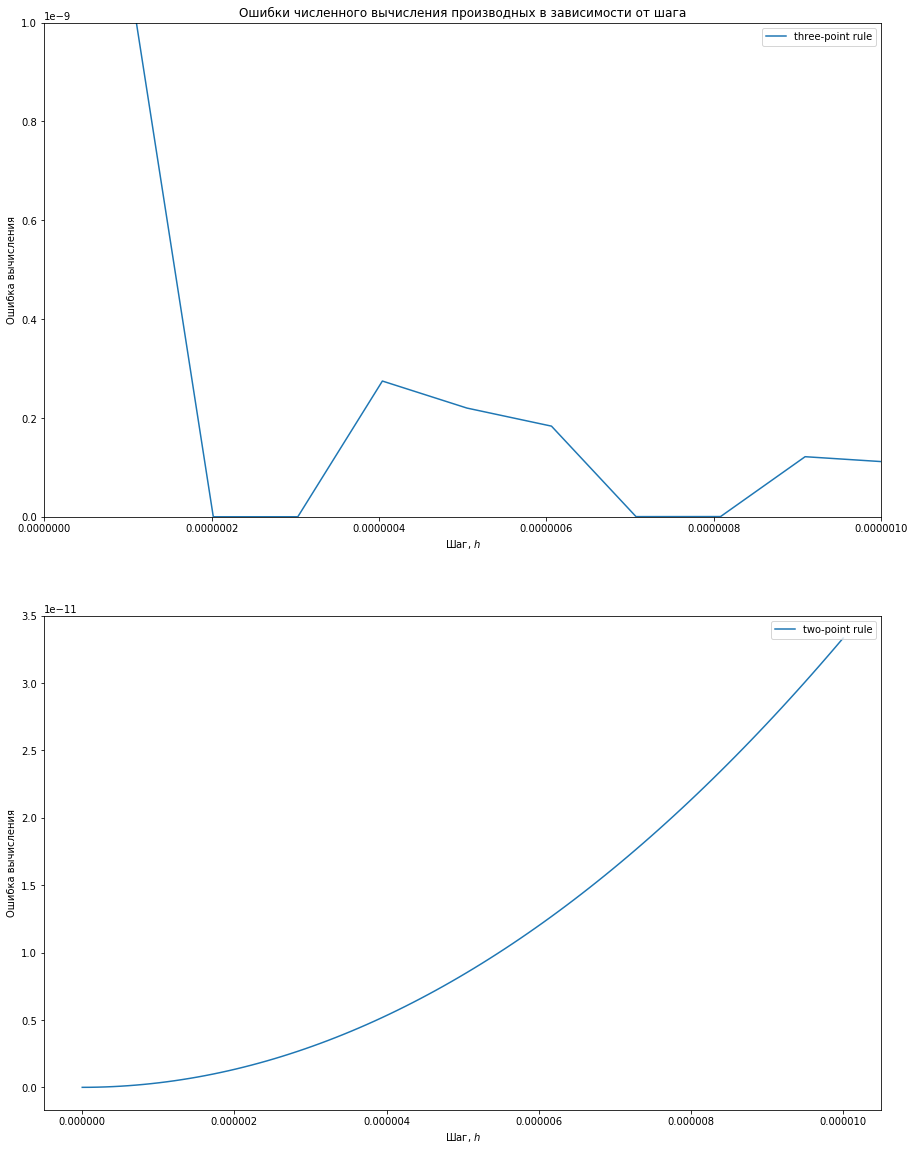

In [52]:
def thrp_deriv(f, x, h):
    x1 = x + h
    x2 = x + 2*h
    h = x1 - x 
    return (- 1.5 * f(x) + 2 * f(x1) - 0.5 * f(x2)) / h
    
import numpy as np
import matplotlib.pyplot as plt

x = 1
y = fder(x) #точный ответ
h = np.linspace(1e-12, 1e-5, 100)
thrp = [abs(thrp_deriv(f, x, i) - y) for i in h] #трехточечная производная
tp = [abs(deriv(f, x, i) - y) for i in h] #двухточечная

fig, ax = plt.subplots(nrows = 2, figsize = (15, 20))
ax[:][0].set_title('Ошибки численного вычисления производных в зависимости от шага')
ax[0].set_xlabel('Шаг, $h$')
ax[0].set_ylabel('Ошибка вычисления')
ax[1].set_xlabel('Шаг, $h$')
ax[1].set_ylabel('Ошибка вычисления')
ax[1].plot(h, tp, label = 'two-point rule')
ax[0].plot(h, thrp, label = 'three-point rule')
ax[0].set_ylim(0, 10e-10)
ax[0].set_xlim(1e-20, 1e-6)
ax[1].legend(loc = 'upper right')
ax[0].legend(loc = 'upper right')

Для трехточечной производной $h \approx 10^{-7}$, для двухточечной ошибка неограниченно уменьшается.

### Test I.3 

Now try differentiating $x^2 \log(x)$ at $x=0$. Use the three-point one-sided rule. Note that to evaluate the function at zero, you need to special-case this value. Check the scaling of the error with $h$, explain your results. 
(25% of the total grade)

In [55]:
def f(x):
    if x == 0:
        # the limit of $x^2 log(x)$ at $x-> 0$ is zero, even though log(x) is undefined at x=0
        return 0.0
    else:
        return x**2 * log(x)
    
def fder(x):
    if x == 0:
        return 0.0
    else:
        return x*(2*log(x) + 1)

x = 0
for h in [1e-2, 1e-3, 1e-4, 1e-5]:
    err = thrp_deriv(f, x, h) - fder(x)
    print("%5f -- %7.4g" % (h, err))

0.010000 -- -0.01386
0.001000 -- -0.001386
0.000100 -- -0.0001386
0.000010 -- -1.386e-05


Ошибка становится порядка $h$, несмотря на то, что сам метод мы строили для получения ошибки $h^{2}$. Возможно, это связано с тем, что, со вторыми, третьими и последующими производными имеются проблемы: $f''(x) = 2\ln(x) + 3, f'''(x) = \frac{2}{x} ...$. Тем временем, вторая и третья производные в нуле фигурируют при расчете коэффициентов в трехточечной производной. Значит, применение метода стоит пересмотреть.

# Part II. Midpoint rule 

Write a function which computes a definite integral using the midpoint rule up to a given error, $\epsilon$. Estimate the error by comparing the estimates of the integral at $N$ and $2N$ elementary intervals. 

In [74]:
def midpoint_rule(func, a, b, eps):
    """ Calculate the integral of f from a to b using the midpoint rule.
    
    Parameters
    ----------
    func : callable
        The function to integrate.
    a : float
        The lower limit of integration.
    b : float
        The upper limit of integration.
    eps : float
        The target accuracy of the estimate.
        
    Returns
    -------
    integral : float
        The estimate of $\int_a^b f(x) dx$.
    """
    Q_2n = 0
    k = 0
    
    for i in range(5, 15):
        Q_n = Q_2n
        h = (b - a) / 2**i
        Q_2n = (f(b) + f(a)) * h / 2
        
        for j in range (2**i):
            Q_2n += func(a + h * (1 + 2*j) / 2) * h
            
        if abs(Q_2n - Q_n) < eps:
            k = i
            break
            
    return Q_2n, k

### Test II.1

Test your midpoint rule on a simple integral, which you can calculate by paper and pencil.

Compare the rate of convergence to the expected $O(N^{-2})$ scaling by studying the number of intervals required for a given accuracy $\epsilon$.

Compare the numerical results to the value you calculated by hand. Does the deviation agree with your estimate of the numerical error?
(20% of the total grade)


In [75]:
#let the integral be int_0^1 x^3 dx from 0 to . Expect - 1 / 4

i, n = midpoint_rule(lambda x: x**3, 0, 1, 1e-6)

print('Ошибка вычислений - ', 1/4 - i, ', ожидаемая ошибка метода - ', 1 / 2 ** (2*n))

Ошибка вычислений -  1.1920928955078125e-07 , ожидаемая ошибка метода -  9.5367431640625e-07


Да, метод сходится так, как хотелось теоретически

### Test II.2

Now use your midpoint rule to compute the value of

$$
\int_0^1\! \frac{\sin{\sqrt{x}}}{x}\, dx
$$

up to a predefined accuracy of $\epsilon=10^{-4}$.

Note that the integral contains an integrable singularity at the lower limit. Do calculations two ways: first, do a straightforward computation; next, subtract the singularity. Compare the number of iterations required to achieve the accuracy of $\epsilon$.

(30% of the total grade)

In [77]:
from math import sin, sqrt

#Straightforward computation:
i, n = midpoint_rule(lambda x: sin(sqrt(x))/ x, 0, 1, 10e-4)

print(i, n)

1.887440365332336 0


 Прибавим и вычтем легко интегрируемую функцию с тем же пределом в нуле: $\int^1_0 \frac{\sin(\sqrt{x})}{x} dx = \int^1_0 (\frac{\sin(\sqrt{x})}{x} - \frac{1}{\sqrt{x}}+ \frac{1}{\sqrt{x}}) dx = \int^1_0 (\frac{\sin(\sqrt{x})}{x} - \frac{1}{\sqrt{x}}) dx + 2$

In [81]:
i, n = midpoint_rule(lambda x: sin(sqrt(x))/ x - 1 / sqrt(x), 0, 1, 10e-4)
i += 2

print(i, n)

1.8921470499588062 6


Второй метод сходится дольше, но лучше (сверено с Wolfram Matematica, которой я верю больше, чем себе).